## Fraud Detection in Financial Transactions with AI<br />

<div align="justify">Fraud is a massive problem for online businesses. Millions of consumers are victims of identity theft every year, a number that keeps increasing in the present Data Era. These risks affect big and small companies: all service providers need to protect their customers' data and transactions.</div><br />

<div align="justify">Current majority of systems use transaction rules that ban unusual combinations of features per transaction with high false positives (flagging non-fraudulent customers). These rules are human-made, and tend to be based on experience.</div><br />

<div align="justify">By using an AI solution, we can find fraudulent patterns in our data that we couldn't think of, precisely because these algorithms are made to work based on evidence and not experience. Plus, these solutions are fast and scalable.</div>  

In this project, we will program three different ways of performing anomaly detection in financial datasets for identifying fraudulent transactions: 
- Random Forest
- Logistic Regression
- Auto Enconders

In [317]:
# Libraries

# Basics #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats
import tensorflow as tf

# Data Preprocessing #
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

# Classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Evaluation
from sklearn.metrics import (precision_recall_curve, auc,roc_curve, recall_score, 
                             classification_report, f1_score, precision_recall_fscore_support)

%matplotlib inline

### 1. Fetching & Cleaning Transaction Dataset

#### Dataset

The data was obtained from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).

<div align="justify">Contains transactions made by credit cards in September 2013 during two days by european cardholders.</div><br />

<div align="justify">This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.</div><br />

<div align="justify">The numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, the original features and  background information are not provided.</div><br /> 

- Features V1, V2, … V28 are the principal components obtained with PCA.
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### 2. Exploratory Data Analysis

In [191]:
# Importing data and first look
df = pd.read_csv("creditcard.csv")
print("Data contains {} transactions and {} features".format(df.shape[0], df.shape[1]-1))
display(df.head())
print(df.info())

Data contains 284807 transactions and 30 features


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [50]:
# Numeric EDA
display(df.describe())

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Numeric EDA comments: 
- Fraudulent transactions are **0.172%** of all transactions.
- Max time is 1.999 days. We confirm the data comes from **two days of transactions** starting in second 0 and finishing in second 172792.
- No missing data.

Text(0, 0.5, 'Frequency')

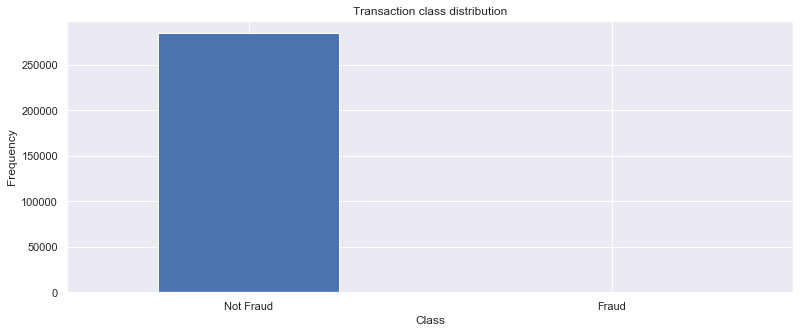

In [206]:
# Visual EDA I "Class Visualization"
sns.set(style="darkgrid", context="notebook")
fig, ax = plt.subplots(figsize=[13,5])

labels=["Not Fraud", "Fraud"]

## Fraudulent transaction proportion
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

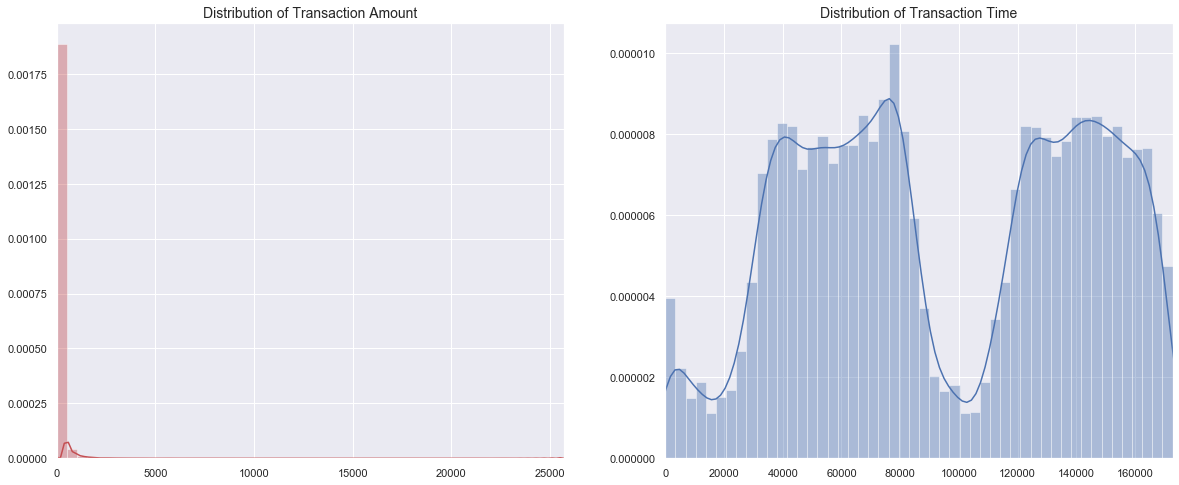

In [203]:
# Visual EDA 2 "Amount and Time Visualizations"
fig, ax = plt.subplots(1, 2, figsize=(20,8))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

Visual EDA Comments

Our data is highly imbalanced, and there are two variables (`Amount` and `Time`) that are not scaled as the others (which are PCA components). For unbalance we will subsample to aid our algorithms with clearer distinguishing what a `Fraud` is. We will be gathering all 492 fraud transactions and randomly select 492 random non-fraud transactions to create a new dataframe. Additionally, we will scale the two variables which are not.  

### 3. Data Preprocessing

In [81]:
# Scaling "Amount" and "Time"

std_scal = StandardScaler()
rob_scal = RobustScaler() # better with outliers

df['Time_sc'] = rob_scal.fit_transform(df['Time'].values.reshape(-1,1))
df['Amount_sc'] = std_scal.fit_transform(df['Amount'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True) # Removing extra old columns

new_time = df['Time_sc']
new_amount = df['Amount_sc']

df.drop(['Time_sc', 'Amount_sc'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', new_amount)
df.insert(1, 'scaled_time', new_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Let's divide and save the original data for future testing once the algorithms are done

In [321]:
print('Not Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# We separate the original X, y and use the stratified kfold to obtain the samples we need

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Transform to array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

Not Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

In [103]:
# We randomly shuffle the data and select all 492 Fraud and the first 492 of the shuffled not Fraud.
df = df.sample(frac=1)
fraud = df.loc[df['Class'] == 1]
non_fraud = df.loc[df['Class'] == 0][:492]
concatenated_df = pd.concat([fraud, non_fraud])

balanced_df = concatenated_df.sample(frac=1, random_state=18)
print("We have {} balanced cases.".format(balanced_df.shape[0]))
print("Fraud:", len(balanced_df[balanced_df["Class"]==1]))
print("Not Fraud:", len(balanced_df[balanced_df["Class"]==0]))

We have 984 balanced cases.
Fraud: 492
Not Fraud: 492


### 4. Building the Models

In [111]:
X_bal = balanced_df.drop("Class", axis=1)
y_bal = balanced_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

print("Split Shapes")
print("-"*40)
print("Train X: {}, Train y: {}".format(X_train.shape, y_train.shape))
print("Test X: {}, Test y: {}".format(X_test.shape, y_test.shape))

Split Shapes
----------------------------------------
Train X: (787, 30), Train y: (787,)
Test X: (197, 30), Test y: (197,)


#### 4.1. Random Forest: vouching for transparency

In [159]:
# HYPERPARAMETER TUNING

# We will try different hyperparameters with a Cross Validation Grid Search to select the most
# optimal Random Forest. 

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Instantiate the Random Forest
rf = RandomForestRegressor()
# Instantiate the grid search with all options of parameters, and cross validation k=5. 
rf_cv = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# Train the model on training data
rf_cv.fit(X_train, y_train)
print("Best Parameters:", rf_cv.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.7min finished


Best Parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}


In [171]:
# TRAIN AND TEST WITH SELECTED HYPERPARAMETERS

target_names= ["Not Fraud", "Fraud"]
# Base Model
rf = RandomForestRegressor(n_estimators=5)
rf.fit(X_train, y_train)
y_pred_base = np.round(rf.predict(X_test))

print("Base Model Report")
print(classification_report(y_test, y_pred_base, target_names=target_names))
report_base = (classification_report(y_test, y_pred_base, output_dict=True))
# Retrieving base accuracy
acc_base = round(report_base["accuracy"] * 100, 1)
print("Accuracy:", acc_base)

print("\n")
# Tuned Model
rf_tuned = RandomForestRegressor(bootstrap=True, max_depth=110,
                                 max_features=3, min_samples_leaf=3, 
                                 n_estimators=200)
rf_tuned.fit(X_train, y_train)
y_pred_tuned = np.round(rf_tuned.predict(X_test))

print("Tuned Model Report")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))
report_tuned = (classification_report(y_test, y_pred_tuned, output_dict=True))
# Retrieving tuned accuracy
acc_tuned = round(report_tuned["accuracy"] * 100, 1)
print("Accuracy:", acc_tuned)

print("Performance improvement: {}%".format(round(acc_tuned - acc_base, 1)))

Base Model Report
              precision    recall  f1-score   support

   Not Fraud       0.88      0.96      0.92        99
       Fraud       0.96      0.87      0.91        98

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197

Accuracy: 91.4


Tuned Model Report
              precision    recall  f1-score   support

   Not Fraud       0.89      1.00      0.94        99
       Fraud       1.00      0.88      0.93        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197

Accuracy: 93.9
Performance improvement: 2.5%


#### 4.2. Logistic Regression: when we "regress" to "classify"

In [169]:
# HYPERPARAMETER TUNING

# Again, different hyperparameters with a Cross Validation Grid Search to select the most
# optimal Random Forest. 

param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}

# Instantiate the Logistic Regression Algorithm
logreg = LogisticRegression()
# Instantiate the grid search with all options of parameters, and cross validation k=5. 
logreg_cv = GridSearchCV(estimator = logreg, param_grid = param_grid, 
                          cv = 10)

# Train the model on training data
logreg_cv.fit(X_train, y_train)
print("Best Parameters:", logreg_cv.best_params_)

Best Parameters: {'C': 29.763514416313132, 'penalty': 'l2', 'solver': 'liblinear'}


In [179]:
# TRAIN AND TEST WITH SELECTED HYPERPARAMETERS

target_names= ["Not Fraud", "Fraud"]
# Base Model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_base = np.round(logreg.predict(X_test))

print("Base Model Report")
print(classification_report(y_test, y_pred_base, target_names=target_names))
report_base = (classification_report(y_test, y_pred_base, output_dict=True))
# Retrieving base accuracy
acc_base = round(report_base["accuracy"] * 100, 1)
print("Accuracy:", acc_base)

print("\n")
# Tuned Model
logreg_tuned = LogisticRegression(C=29.763514416313132, penalty="l2", solver="liblinear")
logreg_tuned.fit(X_train, y_train)
y_pred_tuned = np.round(logreg_tuned.predict(X_test))

print("Tuned Model Report")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))
report_tuned = (classification_report(y_test, y_pred_tuned, output_dict=True))
# Retrieving tuned accuracy
acc_tuned = round(report_tuned["accuracy"] * 100, 1)
print("Accuracy:", acc_tuned)

print("Performance improvement: {}%".format(round(acc_tuned - acc_base, 1)))

Base Model Report
              precision    recall  f1-score   support

   Not Fraud       0.90      0.96      0.93        99
       Fraud       0.96      0.90      0.93        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197

Accuracy: 92.9


Tuned Model Report
              precision    recall  f1-score   support

   Not Fraud       0.91      0.97      0.94        99
       Fraud       0.97      0.90      0.93        98

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197

Accuracy: 93.4
Performance improvement: 0.5%


#### 4.3. Autoencoder: Unsupervised Machine Learning

Autoenconders are a special type of Neural Networks. The number of neurons is equal in input and output. The "magic" comes in the middle of the architecture. We install a "bottleneck" to force the network to represent the input as small as possible (encoder) and ask it to turn it back to its original shape on its own (decoder). We are creating sparse representation of the input data. In other words, we are denoising our data and finding its structure.

In [264]:
# For the autoencoder to work, we will be using the whole dataset, clean, from scratch. Just this
# time we are droping the "time" column but still rescaling the "amount" one. 
df = pd.read_csv("creditcard.csv")
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training will also vary A LOT from regular neuron models. We will force the autoencoder to be able to represent the NON FRAUD transactions as perfectly as possible, so when we will add the FRAUD data, it will recognise it immediately. 

In [266]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

Our autoencoder:
- 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. 
- First two layers are used as encoder, 
- Last two go for the decoder. Additionally, 
- L1 regularization

In [267]:
# BUILDING the Autoencoder
input_dim = X_train.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [268]:
# TRAINING the AUTOENCODER and saving it for later evaluation
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 31s 137us/step - loss: 0.8322 - accuracy: 0.5729 - val_loss: 0.8078 - val_accuracy: 0.6297
Epoch 2/100
227451/227451 [==============================] - 31s 136us/step - loss: 0.7678 - accuracy: 0.6364 - val_loss: 0.7891 - val_accuracy: 0.6519
Epoch 3/100
227451/227451 [==============================] - 33s 143us/step - loss: 0.7552 - accuracy: 0.6527 - val_loss: 0.7795 - val_accuracy: 0.6580
Epoch 4/100
227451/227451 [==============================] - 33s 143us/step - loss: 0.7477 - accuracy: 0.6631 - val_loss: 0.7745 - val_accuracy: 0.6627
Epoch 5/100
227451/227451 [==============================] - 33s 143us/step - loss: 0.7431 - accuracy: 0.6692 - val_loss: 0.7721 - val_accuracy: 0.6688
Epoch 6/100
227451/227451 [==============================] - 33s 143us/step - loss: 0.7409 - accuracy: 0.6726 - val_loss: 0.7740 - val_accuracy: 0.6705
Epoch 7/100
227451/227451 [==========

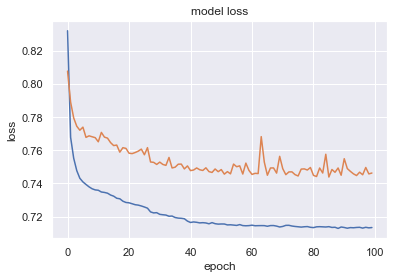

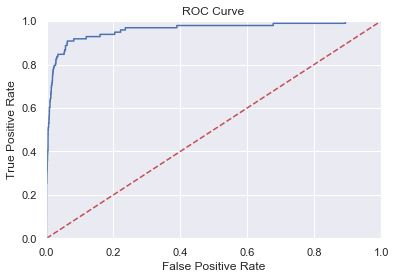

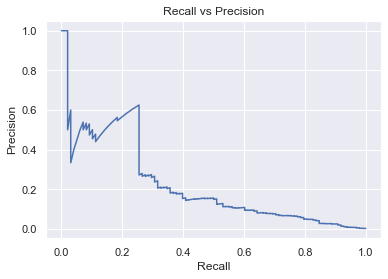

In [319]:
# Accuracy performance during training
autoencoder = load_model('model.h5')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# ROC CURVE
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)

plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Recall vs. Precision
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### 5. Performance Reports and Conclusions

Random Forest Report
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      0.99     56863
       Fraud       0.00      0.03      0.01        98

    accuracy                           0.99     56961
   macro avg       0.50      0.51      0.50     56961
weighted avg       1.00      0.99      0.99     56961

Accuracy: 98.6


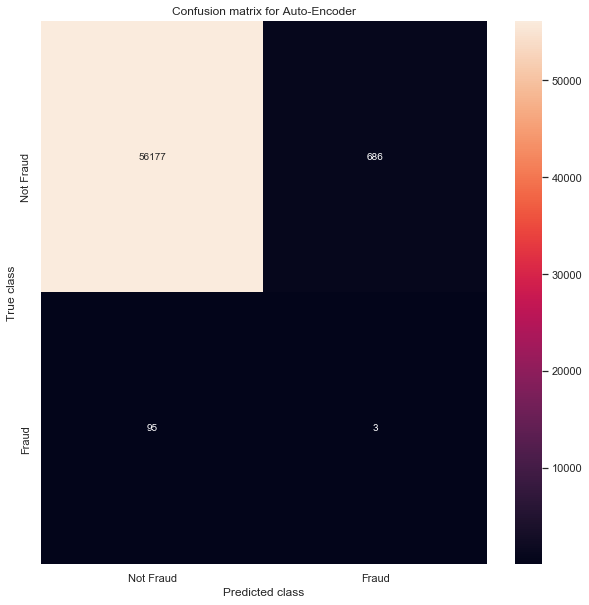


Logistic Regression Report
              precision    recall  f1-score   support

   Not Fraud       0.00      0.00      0.00     56863
       Fraud       0.00      1.00      0.00        98

    accuracy                           0.00     56961
   macro avg       0.00      0.50      0.00     56961
weighted avg       0.00      0.00      0.00     56961

Accuracy: 0.2


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


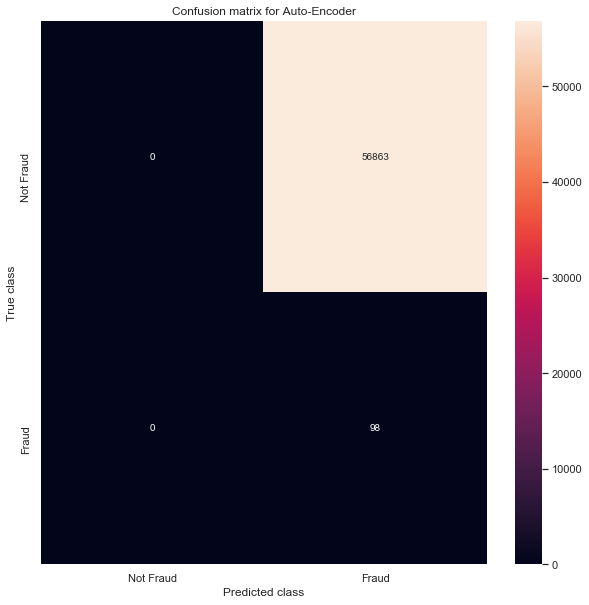

In [320]:
# Complete Dataset Predictions and Evaluation

# Random Forest Report
rf_pred = np.round(rf_tuned.predict(original_Xtest))

print("Random Forest Report")
print(classification_report(original_ytest, rf_pred, target_names=target_names))
report_tuned = (classification_report(original_ytest, rf_pred, output_dict=True))
# Retrieving tuned accuracy
acc_tuned = round(report_tuned["accuracy"] * 100, 1)
print("Accuracy:", acc_tuned)


# Visualizing RF
conf_matrix = confusion_matrix(original_ytest, rf_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix for Auto-Encoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print("")
# Logistic Regression Report
logreg_pred = np.round(logreg_tuned.predict(original_Xtest))

print("Logistic Regression Report")
print(classification_report(original_ytest, logreg_pred, target_names=target_names))
report_tuned = (classification_report(original_ytest, logreg_pred, output_dict=True))

acc_tuned = round(report_tuned["accuracy"] * 100, 1)
print("Accuracy:", acc_tuned)

# Visualizing LR
conf_matrix = confusion_matrix(original_ytest, logreg_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix for Auto-Encoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

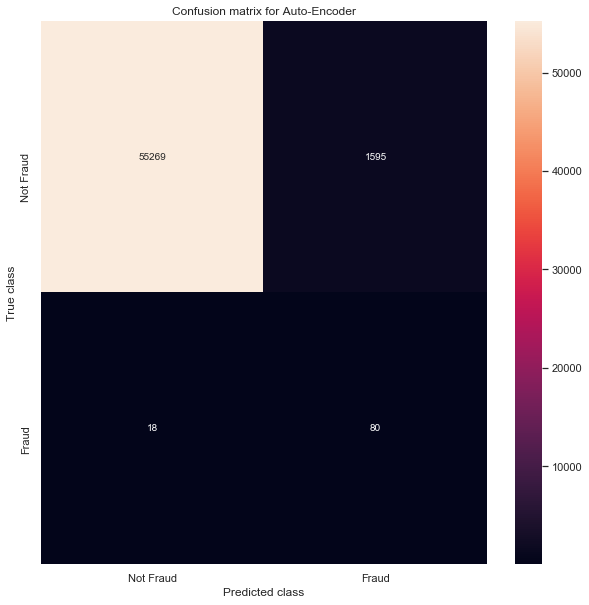

In [314]:
# Auto-Encoder Report

threshold = 2.5 # Max error threshold permited

# Building Confusion Matrix
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)


# Visualizing
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix for Auto-Encoder")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Final Comments
    
To draw a comparative between the algorithms we are reporting two numbers: % of Fraud transactions detected (TP), and % of legit transactions reported as fraud (FP)
Conclusions:
- Random Forest:...3.06%  (TP)...24.7% (FP)
- Log. Regression:...100%  (TP)...100% (FP)
- Auto-Encoder:......78.4% (TP).....2.8%  (FP)

<br>   

The random forest worked relatively bad. On the other hand, the LogReg algorithm seemed to have opted for a "classify all them as FRAUD" strategy that makes it not useful for implementation, mabybe because it is a linear classifier. The most reasonable results were obtained with the unsupervised algorithm, the Auto-Encoder, which detected almost an 80% of the fraud transaction with a very small percentage of False Positives. Following our procedure, we would definitely select the Auto-Encoder for rework and implementation. 